<div class='bar_title'></div>

*Decision Support Systems*

# Headline

student1, student2, student3, student,4 <br>

Winter Semester 19/20

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Supply-Network" data-toc-modified-id="Supply-Network-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Supply Network</a></span></li><li><span><a href="#Distances" data-toc-modified-id="Distances-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Distances</a></span></li><li><span><a href="#Additional-Data" data-toc-modified-id="Additional-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Additional Data</a></span></li><li><span><a href="#Continued" data-toc-modified-id="Continued-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Continued</a></span></li></ul></li></ul></div>

In [1]:
!pip install pulp
!pip install geopy

from pulp import *
from geopy.distance import great_circle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx

## Data

In [2]:
shipping = {
    ('LosMiranas','Medellin'): [99999, 5, 0.2],
    ('Curillo','Medellin'): [99999, 5, 0.2],
    ('Segovia','Medellin'): [99999, 5, 0.2],
    
    ('Medellin','NewYork'): [500, 3, 1], 
    ('Medellin','Miami'): [1000, 3, 1],
    
    ('Medellin','Varadero'): [5000, 10, 1],
    
    ('Varadero','NewYork'): [3000, 5, 1], 
    ('Varadero','Miami'): [4000, 15, 1],
    
    ('Medellin','NuevoLaredo'): [5000, 5, 1],
    
    ('NuevoLaredo','NewYork'): [2000, 10, 1], 
    ('NuevoLaredo','Miami'): [4000, 10, 1],     
}

links = list(shipping.keys())

### Supply Network

C:\Users\Toni Greif\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


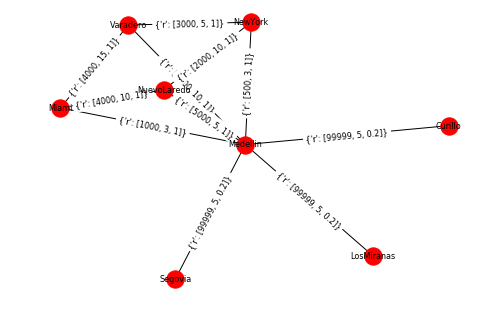

In [3]:
G = nx.Graph()
for (i,j) in links:
    G.add_edge(i, j, r=(shipping[(i,j)]))

    
pos = nx.spring_layout(G, scale=2)

edge_labels = nx.get_edge_attributes(G,'r')

nx.draw(G, pos, font_size=8, with_labels=True)

nx.draw_networkx_edge_labels(G, pos=pos, labels = edge_labels, node_size=60, font_size=8)

plt.show()

### Distances

In [4]:
locations = {
    'LosMiranas': (-1.320259, -70.811026),
    'Curillo': (1.032862, -75.919891),
    'Segovia': (7.078689, -74.700168),
    
    'Medellin': (6.250175, -75.572972), 
    'Varadero': (23.177815, -81.200339),
    'NuevoLaredo': (27.464579, -99.545107),
    
    'NewYork': (40.706773, -74.010585), 
    'Miami': (25.758597, -80.190835)    
}

In [5]:
dist = pd.DataFrame([[great_circle(locations[i],locations[j]).km for i in locations] for j in locations])

dist.columns = locations
dist.index = locations

In [6]:
dist

,LosMiranas,Curillo,Segovia,Medellin,Varadero,NuevoLaredo,NewYork,Miami
LosMiranas,0.000000,625.405343,1028.793964,994.015054,2947.051773,4436.319685,4684.430496,3175.394061
Curillo,625.405343,0.000000,685.731268,581.414610,2527.520475,3870.025141,4415.741427,2787.224898
Segovia,1028.793964,685.731268,0.000000,133.339007,1920.286961,3463.026031,3739.904367,2157.199936
Medellin,994.015054,581.414610,133.339007,0.000000,1976.356181,3459.581054,3834.557783,2224.021630
Varadero,2947.051773,2527.520475,1920.286961,1976.356181,0.000000,1902.380226,2061.887379,304.611024
NuevoLaredo,4436.319685,3870.025141,3463.026031,3459.581054,1902.380226,0.000000,2758.622064,1931.475359
NewYork,4684.430496,4415.741427,3739.904367,3834.557783,2061.887379,2758.622064,0.000000,1757.500063
Miami,3175.394061,2787.224898,2157.199936,2224.021630,304.611024,1931.475359,1757.500063,0.000000


### Additional Data

In [7]:
supply = {
    'LosMiranas': 15000,
    'Curillo': 9000,
    'Segovia': 11000,
}

demand = {
    'NewYork': 7000, 
    'Miami': 8000    
}

price = {
    'NewYork': 100000, 
    'Miami': 80000    
}

In [8]:
# Create model
m = LpProblem("Medellin Cartel", sense=pulp.LpMaximize)

# Variables
x = LpVariable.dicts("amount", links, lowBound=0, cat='Continuous')

# Objective
m += lpSum([dist[i][j] * shipping[(i,j)][1] * x[(i,j)] for (i,j) in links] + [
    price[j]*x[(i,j)] for (i,j) in links if j in price])

# Constraints
for (i,j) in links:
    m += x[(i,j)]<=shipping[(i,j)][0], "Max Flow:%s_%s"%(i,j)
    
for n in locations:
    if n in supply:
        m += (supply[n]) >= (lpSum([x[(i,j)] for (i,j) in links if i==n])), "Flow Conservation in Node:%s"%n
    elif n in demand:
        m += (lpSum([x[(i,j)]*shipping[(i,j)][2] for (i,j) in links if j==n])) <= (demand[n]), "Flow Conservation in Node:%s"%n
    else:
        m += (lpSum([x[(i,j)]*shipping[(i,j)][2] for (i,j) in links if j==n])) >= (lpSum([x[(i,j)] for (i,j) in links if i==n])), "Flow Conservation in Node:%s"%n

In [9]:
# Optimize
m.solve()

# Print the status of the solved LP
print("Status = %s" % LpStatus[m.status])
print("Total Cost = %f" % value(m.objective))

# Print the value of the variables at the optimum
for l in links:
    if(x[l].varValue > 0):
        print("%s: %f" % (x[l].name, x[l].varValue))
        
print("Constraint  | Shadow Price | Slack")
for c in m.constraints:
    print("%s | %f | %f"  %(c, m.constraints[c].pi, m.constraints[c].slack))

Status = Optimal
Total Cost = 1021260997.545646
amount_('LosMiranas',_'Medellin'): 15000.000000
amount_('Curillo',_'Medellin'): 9000.000000
amount_('Segovia',_'Medellin'): 11000.000000
amount_('Medellin',_'Varadero'): 3000.000000
amount_('Varadero',_'NewYork'): 3000.000000
amount_('Medellin',_'NuevoLaredo'): 4000.000000
amount_('NuevoLaredo',_'NewYork'): 2000.000000
amount_('NuevoLaredo',_'Miami'): 2000.000000
Constraint  | Shadow Price | Slack
Max_Flow:LosMiranas_Medellin | -0.000000 | 84999.000000
Max_Flow:Curillo_Medellin | -0.000000 | 90999.000000
Max_Flow:Segovia_Medellin | -0.000000 | 88999.000000
Max_Flow:Medellin_NewYork | -0.000000 | 500.000000
Max_Flow:Medellin_Miami | -0.000000 | 1000.000000
Max_Flow:Medellin_Varadero | -0.000000 | 2000.000000
Max_Flow:Varadero_NewYork | 13460.340000 | -0.000000
Max_Flow:Varadero_Miami | -0.000000 | 4000.000000
Max_Flow:Medellin_NuevoLaredo | -0.000000 | 1000.000000
Max_Flow:NuevoLaredo_NewYork | 28271.467000 | -0.000000
Max_Flow:NuevoLaredo

### Continued

In [10]:
prob = {'S1': [0.3, {
    ('LosMiranas', 'Medellin'): 0,
    ('Curillo', 'Medellin'): 1,
    ('Segovia', 'Medellin'): 1,
    ('Medellin', 'NewYork'): 1,
    ('Medellin', 'Miami'): 1,
    ('Medellin', 'Varadero'): 1,
    ('Varadero', 'NewYork'): 1,
    ('Varadero', 'Miami'): 1,
    ('Medellin', 'NuevoLaredo'): 1,
    ('NuevoLaredo', 'NewYork'): 1,
    ('NuevoLaredo', 'Miami'): 1}],
        'S2': [0.1, {
    ('LosMiranas', 'Medellin'): 1,
    ('Curillo', 'Medellin'): 1,
    ('Segovia', 'Medellin'): 1,
    ('Medellin', 'NewYork'): 1,
    ('Medellin', 'Miami'): 1,
    ('Medellin', 'Varadero'): 1,
    ('Varadero', 'NewYork'): 1,
    ('Varadero', 'Miami'): 0,
    ('Medellin', 'NuevoLaredo'): 1,
    ('NuevoLaredo', 'NewYork'): 1,
    ('NuevoLaredo', 'Miami'): 0}],
        'S3': [0.6, {
    ('LosMiranas', 'Medellin'): 1,
    ('Curillo', 'Medellin'): 1,
    ('Segovia', 'Medellin'): 1,
    ('Medellin', 'NewYork'): 1,
    ('Medellin', 'Miami'): 1,
    ('Medellin', 'Varadero'): 1,
    ('Varadero', 'NewYork'): 1,
    ('Varadero', 'Miami'): 1,
    ('Medellin', 'NuevoLaredo'): 1,
    ('NuevoLaredo', 'NewYork'): 1,
    ('NuevoLaredo', 'Miami'): 1}]
}

scenarios = list(prob.keys())

In [23]:
first = links[:3]
second = links[3:]

In [24]:
# Create model
m = LpProblem("Medellin Cartel", sense=pulp.LpMaximize)

# Non-recourse variables
x = LpVariable.dicts("amount", first, lowBound=0, cat='Continuous')

# Recourse variables
y = LpVariable.dicts("amount", (second,prob), lowBound=0, cat='Continuous')

In [25]:
# Objective
m += lpSum([dist[i][j] * shipping[(i,j)][1] * x[(i,j)] for (i,j) in first] + [
    prob[s][0] * dist[i][j] * shipping[(i,j)][1] * y[(i,j)][s] for (i,j) in second for s in scenarios] + [
    prob[s][0] * price[j] * y[(i,j)][s] * prob[s][1][(i,j)] for (i,j) in second if j in price for s in scenarios])

# Constraints
for (i,j) in first:
    m += x[(i,j)] <= shipping[(i,j)][0], "Max Flow:%s_%s"%(i,j)

for (i,j) in second:
    for s in scenarios:
        m += y[(i,j)][s] <= shipping[(i,j)][0], "Max Flow:%s_%s_%s"%(i,j,s)
    
for n in locations:
    if n in supply:
        m += (supply[n]) >= (lpSum([x[(i,j)] for (i,j) in first if i==n])), "Flow Conservation in Node:%s"%n
    elif n in demand:
        for s in scenarios:
            m += (lpSum([y[(i,j)][s]*shipping[(i,j)][2] for (i,j) in second if j==n])) <= (demand[n]), "Flow Conservation in Node:%s_%s"%(n,s)
    else:
        for s in scenarios:
            m += (lpSum([x[(i,j)]* prob[s][1][(i,j)] * shipping[(i,j)][2] for (i,j) in first if j==n] + [
                         y[(i,j)][s]*shipping[(i,j)][2] for (i,j) in second if j==n])) >= (lpSum([y[(i,j)][s] for (i,j) in second if i==n])), "Flow Conservation in Node:%s_%s"%(n,s)

In [29]:
# Optimize
m.solve()

# Print the status of the solved LP
print("Status = %s" % LpStatus[m.status])
print("Total Cost = %f" % value(m.objective))

# Print the value of the variables at the optimum
for l in first:
    if(x[l].varValue > 0):
        print("%s: %f" % (x[l].name, x[l].varValue))
        
for l in second:
    for s in scenarios:
        if(y[l][s].varValue > 0):
            print("%s: %f" % (y[l][s].name, y[l][s].varValue))
        
print("Constraint  | Shadow Price | Slack")
for c in m.constraints:
    print("%s | %f | %f"  %(c, m.constraints[c].pi, m.constraints[c].slack))

Status = Optimal
Total Cost = 905021993.942468
amount_('LosMiranas',_'Medellin'): 15000.000000
amount_('Curillo',_'Medellin'): 9000.000000
amount_('Segovia',_'Medellin'): 11000.000000
amount_('Medellin',_'NewYork')_S2: 500.000000
amount_('Medellin',_'Miami')_S2: 1000.000000
amount_('Medellin',_'Varadero')_S1: 2000.000000
amount_('Medellin',_'Varadero')_S2: 3000.000000
amount_('Medellin',_'Varadero')_S3: 3000.000000
amount_('Varadero',_'NewYork')_S1: 2000.000000
amount_('Varadero',_'NewYork')_S2: 3000.000000
amount_('Varadero',_'NewYork')_S3: 3000.000000
amount_('Medellin',_'NuevoLaredo')_S1: 2000.000000
amount_('Medellin',_'NuevoLaredo')_S2: 2500.000000
amount_('Medellin',_'NuevoLaredo')_S3: 4000.000000
amount_('NuevoLaredo',_'NewYork')_S1: 2000.000000
amount_('NuevoLaredo',_'NewYork')_S2: 2000.000000
amount_('NuevoLaredo',_'NewYork')_S3: 2000.000000
amount_('NuevoLaredo',_'Miami')_S2: 500.000000
amount_('NuevoLaredo',_'Miami')_S3: 2000.000000
Constraint  | Shadow Price | Slack
Max_Flo